In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# from scipy.stats import binned_statistic_2d
# from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.cm as cm

# from abacusnbody.analysis.tsc import tsc_parallel
import time

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

# Import packages

sys.path.append('../src/')
# from filter_utils import *
# from SZstacker import SZMapStacker # type: ignore
from utils import ksz_from_delta_sigma, arcmin_to_comoving, comoving_to_arcmin

from stacker import SimulationStacker

import illustris_python as il

import yaml
import argparse
from pathlib import Path


In [3]:
# Configuration parameters
sim_type = 'IllustrisTNG'
snapshot = 74
sim_name = 'L50n512_SB35'

load_field = False
save_field = False
rad_distance = 1.0  # in arcmin
mask_haloes = False
mask_radii = 3.0  # Number of virial radii to mask out for haloes. In units of R200c

min_radius = 1/6
max_radius = 6.0
num_radii = 15

projection = 'xy'  # 'xy', 'xz', 'yz'

### Profile parameters
pixel_size = 0.5  # in arcmin
filter_type = 'CAP'  # Options: 'CAP', 'cumulative', 'DSigma'
particle_type = 'tau'

n_pixels = 1000
filter_type_2 = 'DSigma'  # Options: 'CAP', 'cumulative', 'DSigma'
particle_type_2 = 'total'

### Physical parameters
number_densities = [1.0e-4, 2.8e-4, 5.4e-4, 1.0e-3, 2.4e-3]


# ✅ $P_k$ Suppression Consistency Check with 1-st Data Generation

Keys in the power spectrum file:
  k
  PX_dm_tot
  P_dm
  P_tot
  r
  XX_dm_tot
  X_dm
  X_tot
Reference data shape: (1024, 255)
New data shape: (1024, 255)
Reference data shape: (1024, 255)
New data shape: (1024, 255)


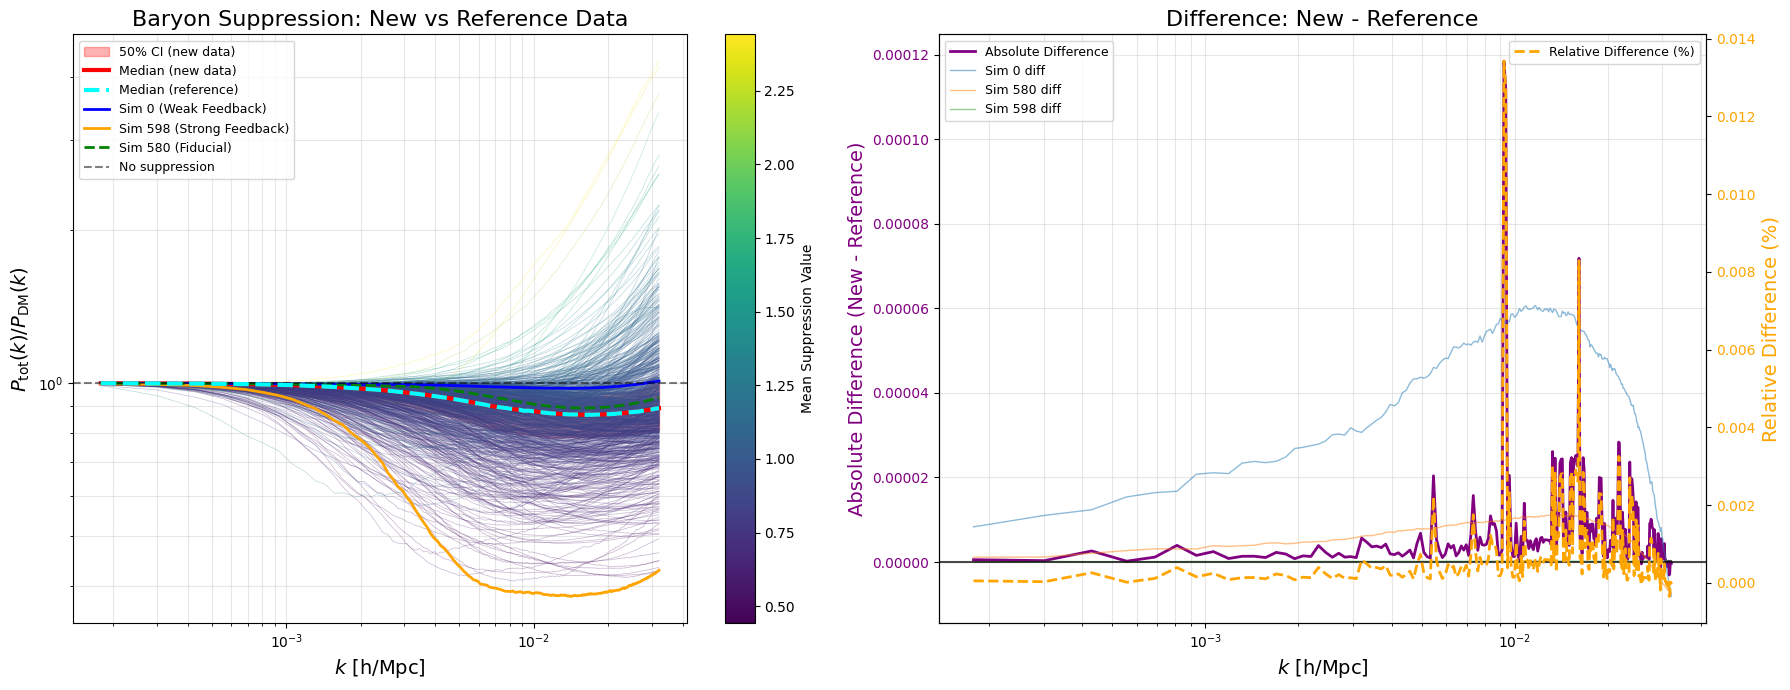


=== Comparison Summary ===
Mean absolute difference (median): 7.235857e-06
Max absolute difference (median): 1.184954e-04
Mean relative difference (median): 0.001%
Max relative difference (median): 0.013%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

sims = np.arange(1024)  # Your simulation IDs
base_path_template = '/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_{}/data/'

all_sims_pk_data = []

# Load data for all simulations
for sim_id in sims:
    profile_file = base_path_template.format(sim_id) + 'Pk_512_3Dfield.npz'  # Update filename
    loaded_data = np.load(profile_file)
    all_sims_pk_data.append(loaded_data)
    
    # Print keys from first simulation to see what's available
    if sim_id == sims[0]:
        print("Keys in the power spectrum file:")
        for key in loaded_data.keys():
            print(f"  {key}")

# Compute suppression ratios for all simulations
k = all_sims_pk_data[0]['k']
Ptot_Pdm_ratio = []
for pk_data in all_sims_pk_data:
    suppression = pk_data['P_tot'] / pk_data['P_dm']
    Ptot_Pdm_ratio.append(suppression)

Ptot_Pdm_ratio = np.array(Ptot_Pdm_ratio)

# Load reference data from previous computation
Ptot_Pdm_ratio_ref = np.load('/pscratch/sd/l/lindajin/DH_profile_kSZ_WL/data/Ptot_Pdm_ratio_sims_halos.npy')
print(f"Reference data shape: {Ptot_Pdm_ratio_ref.shape}")
print(f"New data shape: {Ptot_Pdm_ratio.shape}")

# Compute mean suppression value for each simulation (for coloring)
mean_values = np.mean(Ptot_Pdm_ratio, axis=1)

# Compute median and percentiles across all simulations
median_Pk_tot_dm = np.median(Ptot_Pdm_ratio, axis=0)
p25 = np.percentile(Ptot_Pdm_ratio, 25, axis=0)
p75 = np.percentile(Ptot_Pdm_ratio, 75, axis=0)
yerr_Pk_tot_dm = [median_Pk_tot_dm - p25, p75 - median_Pk_tot_dm]

# Compute median for reference data
median_Pk_tot_dm_ref = np.median(Ptot_Pdm_ratio_ref, axis=0)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# === LEFT PLOT: Overlay comparison ===
# Normalize based on the range of mean values
norm = colors.Normalize(vmin=np.min(mean_values), vmax=np.max(mean_values))
cmap = cm.viridis

# Plot each simulation with a different color based on its mean value
for i, sim_data in enumerate(Ptot_Pdm_ratio):
    color = cmap(norm(mean_values[i]))
    ax1.plot(k, sim_data, alpha=0.3, linewidth=0.5, color=color)

# Plot the median with error bars on top
ax1.fill_between(k, median_Pk_tot_dm - yerr_Pk_tot_dm[0], median_Pk_tot_dm + yerr_Pk_tot_dm[1], 
                 alpha=0.3, color='red', label='50% CI (new data)')
ax1.plot(k, median_Pk_tot_dm, linewidth=3, color='red', label='Median (new data)')

# Overlay reference median
# Need to match k-values - assuming reference uses same or subset of k
k_ref_indices = slice(None, Ptot_Pdm_ratio_ref.shape[1])  # Use available reference k points
ax1.plot(k[k_ref_indices], median_Pk_tot_dm_ref, linewidth=3, color='cyan', 
         linestyle='--', label='Median (reference)', zorder=10)

# Highlight specific simulations
ax1.plot(k, Ptot_Pdm_ratio[0], linewidth=2, color='blue', label='Sim 0 (Weak Feedback)')
ax1.plot(k, Ptot_Pdm_ratio[598], linewidth=2, color='orange', label='Sim 598 (Strong Feedback)')
ax1.plot(k, Ptot_Pdm_ratio[580], linewidth=2, color='green', ls='--', label='Sim 580 (Fiducial)')

# Formatting
ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='No suppression')
ax1.set_xlabel(r'$k$ [h/Mpc]', fontsize=14)
ax1.set_ylabel(r'$P_{\rm tot}(k) / P_{\rm DM}(k)$', fontsize=14)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3, which='both')
ax1.set_title('Baryon Suppression: New vs Reference Data', fontsize=16)

# Add colorbar to show what the background colors represent
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, label='Mean Suppression Value')

# === RIGHT PLOT: Difference quantification ===
# Compute difference between new and reference medians
k_common = k[k_ref_indices]
diff_median = median_Pk_tot_dm[k_ref_indices] - median_Pk_tot_dm_ref
rel_diff_median = (median_Pk_tot_dm[k_ref_indices] - median_Pk_tot_dm_ref) / median_Pk_tot_dm_ref * 100

# Plot absolute difference
ax2_twin = ax2.twinx()
ax2.plot(k_common, diff_median, linewidth=2, color='purple', label='Absolute Difference')
ax2_twin.plot(k_common, rel_diff_median, linewidth=2, color='orange', 
              linestyle='--', label='Relative Difference (%)')

# Also show per-simulation differences for a few examples
for sim_idx in [0, 580, 598]:
    diff_sim = Ptot_Pdm_ratio[sim_idx, k_ref_indices] - Ptot_Pdm_ratio_ref[sim_idx]
    ax2.plot(k_common, diff_sim, linewidth=1, alpha=0.5, 
             label=f'Sim {sim_idx} diff')

ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
ax2.set_xlabel(r'$k$ [h/Mpc]', fontsize=14)
ax2.set_ylabel('Absolute Difference (New - Reference)', fontsize=14, color='purple')
ax2_twin.set_ylabel('Relative Difference (%)', fontsize=14, color='orange')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor='purple')
ax2_twin.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper left', fontsize=9)
ax2_twin.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3, which='both')
ax2.set_title('Difference: New - Reference', fontsize=16)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Comparison Summary ===")
print(f"Mean absolute difference (median): {np.mean(np.abs(diff_median)):.6e}")
print(f"Max absolute difference (median): {np.max(np.abs(diff_median)):.6e}")
print(f"Mean relative difference (median): {np.mean(np.abs(rel_diff_median)):.3f}%")
print(f"Max relative difference (median): {np.max(np.abs(rel_diff_median)):.3f}%")

In [16]:
# Verify data integrity - check for None types or missing files
print("=== Data Integrity Check ===")
missing_sims = []
none_type_sims = []
shape_mismatch_sims = []
nan_inf_sims = {}

required_keys = ['k', 'PX_dm_tot', 'P_dm', 'P_tot', 'r', 'XX_dm_tot', 'X_dm', 'X_tot']

for i, pk_data in enumerate(all_sims_pk_data):
    if pk_data is None:
        none_type_sims.append(i)
        continue
    
    # Check for missing keys
    missing_keys = [key for key in required_keys if key not in pk_data]
    if missing_keys:
        missing_sims.append((i, missing_keys))
        continue
    
    # Check for shape mismatch
    if pk_data['k'].shape[0] != k.shape[0]:
        shape_mismatch_sims.append(i)
    
    # Check for NaN or Inf values in each array
    for key in required_keys:
        if key in pk_data:
            arr = pk_data[key]
            if np.any(np.isnan(arr)):
                if key not in nan_inf_sims:
                    nan_inf_sims[key] = {'nan': [], 'inf': []}
                nan_inf_sims[key]['nan'].append(i)
            if np.any(np.isinf(arr)):
                if key not in nan_inf_sims:
                    nan_inf_sims[key] = {'nan': [], 'inf': []}
                nan_inf_sims[key]['inf'].append(i)

print(f"Total simulations loaded: {len(all_sims_pk_data)}")
print(f"\nSimulations with None type: {len(none_type_sims)}")
if none_type_sims:
    print(f"  Sim IDs: {none_type_sims[:20]}{'...' if len(none_type_sims) > 20 else ''}")
    
print(f"\nSimulations with missing keys: {len(missing_sims)}")
if missing_sims:
    for sim_id, missing_keys in missing_sims[:10]:
        print(f"  Sim {sim_id}: missing {missing_keys}")
    if len(missing_sims) > 10:
        print(f"  ... and {len(missing_sims) - 10} more")
    
print(f"\nSimulations with shape mismatch: {len(shape_mismatch_sims)}")
if shape_mismatch_sims:
    print(f"  Sim IDs: {shape_mismatch_sims[:20]}{'...' if len(shape_mismatch_sims) > 20 else ''}")

print(f"\nChecking for NaN/Inf values in arrays:")
if nan_inf_sims:
    for key, issues in nan_inf_sims.items():
        if issues['nan']:
            print(f"  {key}: {len(issues['nan'])} sims with NaN - IDs: {issues['nan'][:10]}{'...' if len(issues['nan']) > 10 else ''}")
        if issues['inf']:
            print(f"  {key}: {len(issues['inf'])} sims with Inf - IDs: {issues['inf'][:10]}{'...' if len(issues['inf']) > 10 else ''}")
else:
    print("  ✅ No NaN or Inf values found in any arrays")

total_issues = len(none_type_sims) + len(missing_sims) + len(shape_mismatch_sims) + sum(len(v['nan']) + len(v['inf']) for v in nan_inf_sims.values())

if total_issues == 0:
    print("\n✅ All 1024 simulations loaded successfully with consistent, clean data!")
else:
    print(f"\n⚠️  Found issues in data")
    
print()

=== Data Integrity Check ===
Total simulations loaded: 1024

Simulations with None type: 0

Simulations with missing keys: 0

Simulations with shape mismatch: 0

Checking for NaN/Inf values in arrays:
  ✅ No NaN or Inf values found in any arrays

✅ All 1024 simulations loaded successfully with consistent, clean data!

Total simulations loaded: 1024

Simulations with None type: 0

Simulations with missing keys: 0

Simulations with shape mismatch: 0

Checking for NaN/Inf values in arrays:
  ✅ No NaN or Inf values found in any arrays

✅ All 1024 simulations loaded successfully with consistent, clean data!



# Profiles

In [5]:
profiles_loaded = np.load('/pscratch/sd/l/lindajin/CAMELS/IllustrisTNG/L50n512_SB35/SB35_941/data/Profiles_tau-CAP_total-DSigma.npz')

In [7]:
for key in profiles_loaded.keys():
    print(f"  {key}")

  prof0_tau_CAP_xy
  prof1_total_DSigma_arcmin2_xy
  prof1_total_DSigma_kpch2_xy
  prof0_tau_CAP_xz
  prof1_total_DSigma_arcmin2_xz
  prof1_total_DSigma_kpch2_xz
  prof0_tau_CAP_yz
  prof1_total_DSigma_arcmin2_yz
  prof1_total_DSigma_kpch2_yz
  r0_arcmin
  r0_to_mpch
  r1_mpch
  r1_to_arcmin
  halo_masses
  number_density
  nPixels01
  pixelSize01
  methods01
  units01
